## Package Installation

In [ ]:
%pip install -r requirements.txt

In [1]:
from models.sam import SamPredictor, sam_model_registry
from models.sam.modeling.prompt_encoder import attention_fusion
import numpy as np
import os
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
from dsc import dice_coeff
import torchio as tio
import nrrd
import PIL
import cfg
from funcs import *
from predict_funs import *
args = cfg.parse_args()
from monai.networks.nets import VNet
args.if_mask_decoder_adapter=True
args.if_encoder_adapter = True
args.decoder_adapt_depth = 2
%matplotlib inline

/Users/mandywu/Documents/GitHub/SegmentAnyBone/models/sam/modeling/tiny_vit_sam.py:677: UserWarning: Overwriting tiny_vit_5m_224 in registry with models.sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Users/mandywu/Documents/GitHub/SegmentAnyBone/models/sam/modeling/tiny_vit_sam.py:677: UserWarning: Overwriting tiny_vit_11m_224 in registry with models.sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Users/mandywu/Documents/GitHub/SegmentAnyBone/models/sam/modeling/tiny_vit_sam.py:677: UserWarning: Overwriting tiny_vit_21m_224 in registry with models.sam.modeling.tiny_vit_sam.tiny_vit_21m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expecte

## Load models

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
checkpoint_directory = './' # path to your checkpoint
img_folder = os.path.join('images')
gt_msk_folder = os.path.join('masks')
predicted_msk_folder = os.path.join('predicted_masks')
cls = 1

sam_fine_tune = sam_model_registry["vit_t"](args,checkpoint=os.path.join('mobile_sam.pt'),num_classes=2)
sam_fine_tune.attention_fusion = attention_fusion()  
sam_fine_tune.load_state_dict(torch.load(os.path.join(checkpoint_directory,'bone_sam.pth'),map_location=torch.device(device)), strict = True)
sam_fine_tune = sam_fine_tune.to(device).eval()

vnet = VNet().to(device)
model_directory = "./"
vnet.load_state_dict(torch.load(os.path.join(model_directory,'atten.pth'),map_location=torch.device(device)))

cpu


<All keys matched successfully>

## 2D Slice Prediction & Evaluation

/Users/mandywu/anaconda3/envs/torch/lib/python3.9/site-packages/torchio/transforms/transform.py:163: RuntimeWarning: Output shape (64, 64, 1) != target shape (64, 64, 64). Fixing with CropOrPad
  transformed = self.apply_transform(subject)


dsc_gt: 0.8172484636306763
Saved third image (pre_mask_auto) resized to original size to ./segmentation_results/pre_mask_auto_TD09_S1_MRI_axial_origin_041.png
Saved segmented result to ./segmentation_results/segmented_TD09_S1_MRI_axial_origin_041.png (DSC: 0.8172)


/Users/mandywu/anaconda3/envs/torch/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


dsc_gt: 0.9162701964378357
Saved third image (pre_mask_auto) resized to original size to ./segmentation_results/pre_mask_auto_TD09_S1_MRI_axial_origin_392.png
Saved segmented result to ./segmentation_results/segmented_TD09_S1_MRI_axial_origin_392.png (DSC: 0.9163)
dsc_gt: 0.5785979628562927
Saved third image (pre_mask_auto) resized to original size to ./segmentation_results/pre_mask_auto_TD09_S1_MRI_axial_origin_511.png
Saved segmented result to ./segmentation_results/segmented_TD09_S1_MRI_axial_origin_511.png (DSC: 0.5786)


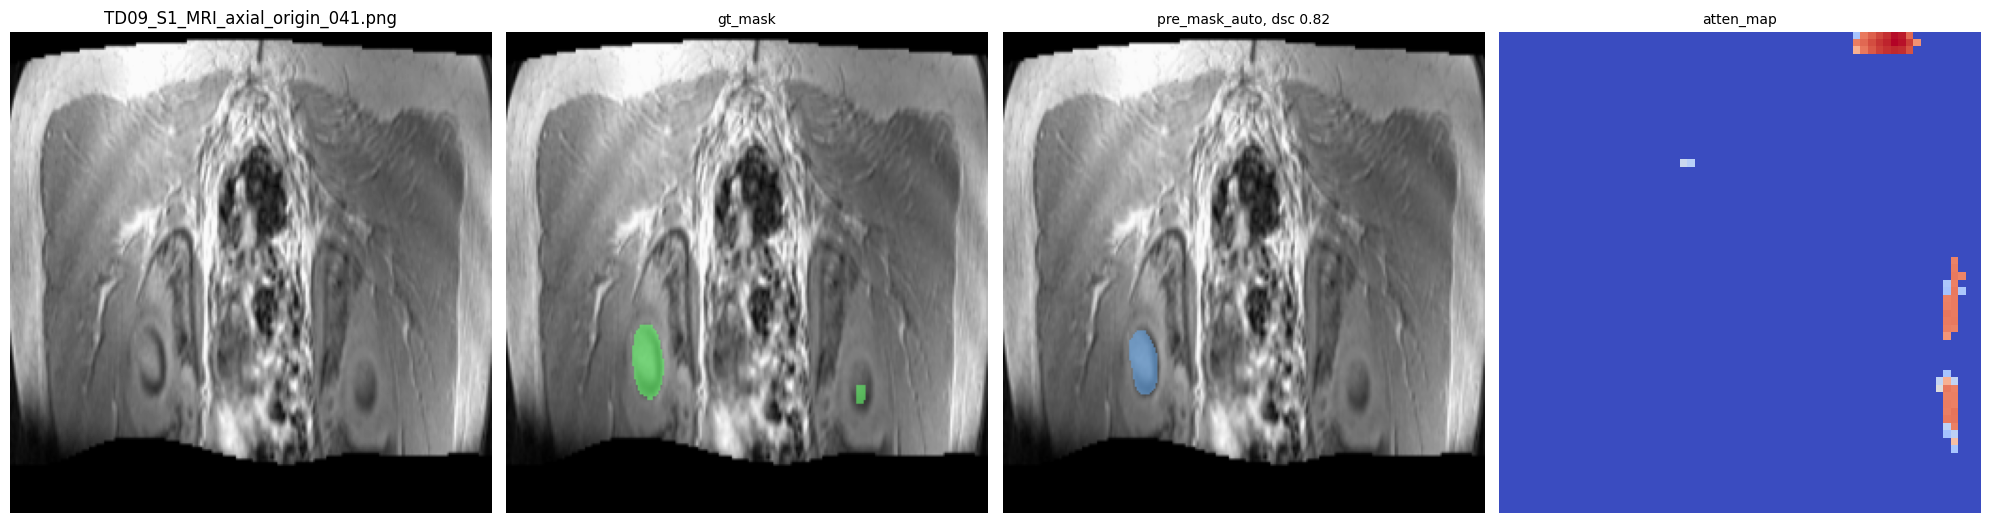

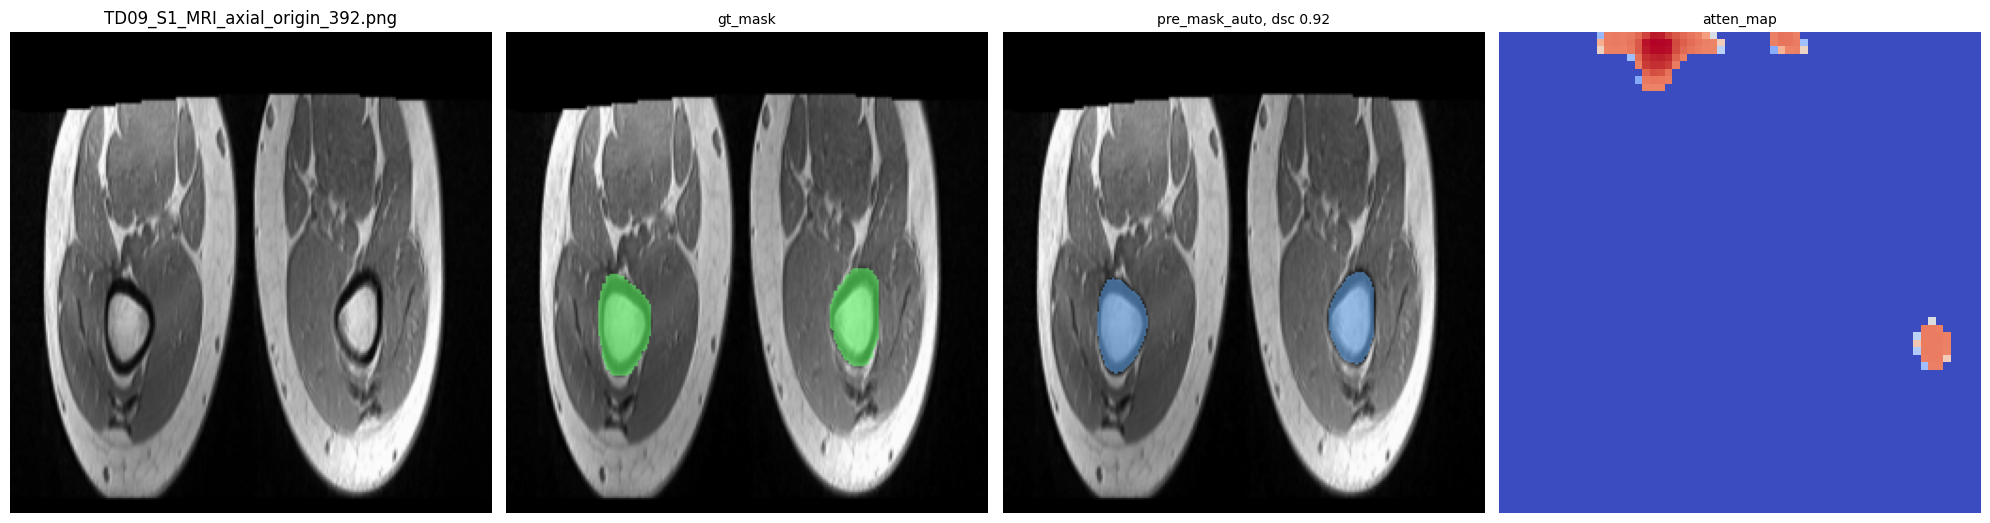

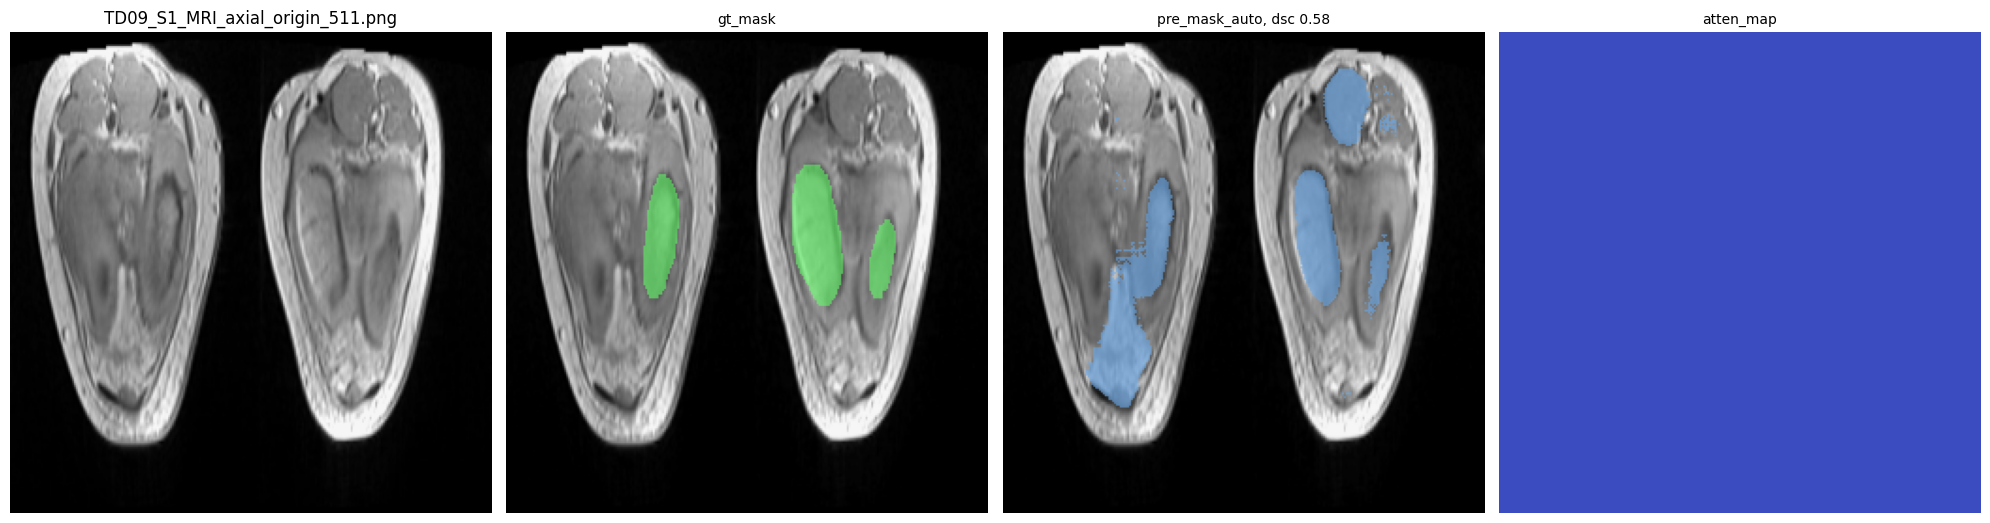

In [18]:
def evaluateSlicePrediction(mask_pred, mask_name, slice_id):
    # Read corresponding PNG mask
    msk = Image.open(os.path.join(gt_msk_folder, f"{mask_name}_{slice_id}.png"))  # Assume mask filename format is "name_sliceid.png"
    msk = transforms.Resize((256,256))(msk)
    # Convert RGB image to grayscale if needed
    if msk.mode != 'L':
        msk = msk.convert('L')
    msk_gt = (transforms.ToTensor()(msk)>0).float()
    
    dsc_gt = dice_coeff(mask_pred.cpu(), msk_gt).item()
    print("dsc_gt:", dsc_gt)
    return msk_gt, dsc_gt

def predictSlice(image_name, lower_percentile, upper_percentile, slice_id, attention_enabled):
    # Read PNG image
    img_path = os.path.join(img_folder, f"{image_name}_{slice_id}.png")
    image = Image.open(img_path)
    if image.mode != 'L':
        image = image.convert('L')
    
    # Convert to tensor and adjust dimensions
    image_tensor = transforms.ToTensor()(image)  # [1, H, W]
    
    # Adjust dimensions to [1, 1, H, W, 1] (channels, x, y, z)
    image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension [1, 1, H, W]
    image_tensor = image_tensor.unsqueeze(-1)  # Add z dimension [1, 1, H, W, 1]
    
    # Data normalization
    lower_bound = torch_percentile(image_tensor, lower_percentile)
    upper_bound = torch_percentile(image_tensor, upper_percentile)
    image_tensor = torch.clamp(image_tensor, lower_bound, upper_bound)
    image_tensor = (image_tensor - lower_bound) / (upper_bound - lower_bound)
    
    # Rearrange dimensions to (1, x, y, z)
    image_tensor = image_tensor.squeeze(0)  # Remove batch dimension
    
    # Create torchio ScalarImage object
    image1_vol = tio.ScalarImage(tensor=image_tensor)
    
    atten_map = pred_attention(image1_vol, vnet, 0, device)  # slice_id set to 0 as we only have one slice
    atten_map = torch.unsqueeze(torch.tensor(atten_map), 0).float().to(device)
    
    if attention_enabled:
        ori_img, pred_1, _, Pil_img1, _ = evaluate_1_volume_withattention(
            image1_vol, sam_fine_tune, device, slice_id=0, atten_map=atten_map)
    else:
        ori_img, pred_1, _, Pil_img1, _ = evaluate_1_volume_withattention(
            image1_vol, sam_fine_tune, device, slice_id=0)
    
    mask_pred = ((pred_1>0)==cls).float().cpu()
    return ori_img, mask_pred, atten_map

def visualizeSlicePrediction(ori_img, image_name, atten_map, msk_gt, mask_pred, dsc_gt, output_folder, original_size):
    # Resize without rotation
    image = torchvision.transforms.Resize((args.out_size,args.out_size))(ori_img)[0]
    image_3d = np.repeat(np.array(image*255,dtype=np.uint8).copy()[:, :, np.newaxis], 3, axis=2)
    
    # Process mask without rotation
    pred_mask_auto = (mask_pred[0])*255
    mask = (msk_gt.cpu()[0]>0)*255
    
    # Draw contours without rotation
    target_prediction = [103,169,237]
    image_pred_auto = drawContour(image_3d.copy(), pred_mask_auto, target_prediction, size=-1, a=0.6)
    
    target_prediction = [100,255,106]
    image_mask = drawContour(image_3d.copy(), mask, target_prediction, size=-1, a=0.6)

    # Save the third image (a[2]) directly
    third_image_output_file = os.path.join(output_folder, f"pre_mask_auto_{image_name}")
    third_image_resized = Image.fromarray(image_pred_auto.astype(np.uint8)).resize(original_size)
    third_image_resized.save(third_image_output_file)
    print(f"Saved third image (pre_mask_auto) resized to original size to {third_image_output_file}")
    
    # Display images
    fig, a = plt.subplots(1,4, figsize=(20,15))
    a[0].imshow(image, cmap='gray', vmin=0, vmax=1)
    a[0].set_title(image_name)
    a[0].axis(False)
    
    a[1].imshow(image_mask, cmap='gray', vmin=0, vmax=255)
    a[1].set_title('gt_mask', fontsize=10)
    a[1].axis(False)
    
    a[2].imshow(image_pred_auto, cmap='gray', vmin=0, vmax=255)
    a[2].set_title('pre_mask_auto, dsc %.2f'%(dsc_gt), fontsize=10)
    a[2].axis(False)
    
    # Display attention map without rotation
    a[3].imshow(atten_map.cpu()[0], vmin=0, vmax=1, cmap='coolwarm')
    a[3].set_title('atten_map', fontsize=10)
    a[3].axis(False)
    
    plt.tight_layout()

def save_segment_results(image_list, mask_list, output_folder, lower_percentile, upper_percentile, attention_enabled):
    """
    Test and save segmentation results for a list of images.

    Args:
        image_list (list): List of image file paths.
        mask_list (list): List of mask file paths corresponding to the images.
        output_folder (str): Folder to save the segmentation results.
        lower_percentile (int): Lower percentile for normalization.
        upper_percentile (int): Upper percentile for normalization.
        attention_enabled (bool): Whether to use the attention map.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for image_path, mask_path in zip(image_list, mask_list):
        # Extract slice ID from filename
        slice_id = os.path.basename(image_path).split('_')[-1].split('.')[0]

        # Extract base names for image and mask
        image_base_name = '_'.join(os.path.basename(image_path).split('_')[:5])  # E.g., "TD09_S1_MRI_axial"
        mask_base_name = '_'.join(os.path.basename(mask_path).split('_')[:6])   # E.g., "TD09_S1_L_femur-label_axial"

        # Perform prediction
        ori_img, predictedSliceMask, atten_map = predictSlice(
            image_name=image_base_name,
            lower_percentile=lower_percentile,
            upper_percentile=upper_percentile,
            slice_id=slice_id,
            attention_enabled=attention_enabled
        )

        # Evaluate prediction
        msk_gt, dsc_gt = evaluateSlicePrediction(
            mask_pred=predictedSliceMask,
            mask_name=mask_base_name,
            slice_id=slice_id
        )

        ## Save segmentation result
        output_file = os.path.join(output_folder, f"segmented_{os.path.basename(image_path)}")
        
        # Resize predicted mask to match original image size
        original_image_path = os.path.join(img_folder, os.path.basename(image_path))
        original_image = Image.open(original_image_path)
        original_size = original_image.size  # Get original size (width, height)

        # Resize mask and save
        segmented_image = (predictedSliceMask[0].cpu().numpy() * 255).astype('uint8')
        segmented_image_resized = Image.fromarray(segmented_image).resize(original_size)
        segmented_image_resized.save(output_file)

        # visualizeSlicePrediction function remains unchanged
        visualizeSlicePrediction(
            ori_img=ori_img,
            image_name=os.path.basename(image_path),
            atten_map=atten_map,
            msk_gt=msk_gt,
            mask_pred=predictedSliceMask,
            dsc_gt=dsc_gt,
            output_folder = output_folder,
            original_size = original_size
        )

        print(f"Saved segmented result to {output_file} (DSC: {dsc_gt:.4f})")

# Test images and masks
test_images = [
    "TD09_S1_MRI_axial_origin_041.png",
    "TD09_S1_MRI_axial_origin_392.png",
    "TD09_S1_MRI_axial_origin_511.png"
]
test_masks = [
    "TD09_S1_L_femur-label_axial_mask_041.png",
    "TD09_S1_L_femur-label_axial_mask_392.png",
    "TD09_S1_L_femur-label_axial_mask_511.png"
]
output_dir = "./segmentation_results"

# Run the test and save results
save_segment_results(test_images, test_masks, output_dir, lower_percentile=1, upper_percentile=99, attention_enabled=True)



Select points for image: ./images/TD09_S1_MRI_axial_origin_041.png
Selected points: [(105, 110), (265, 119)]


/Users/mandywu/anaconda3/envs/torch/lib/python3.9/site-packages/torchio/transforms/transform.py:163: RuntimeWarning: Output shape (64, 64, 1) != target shape (64, 64, 64). Fixing with CropOrPad
  transformed = self.apply_transform(subject)
/var/folders/9_/k4h2cghj2s3bg4nf0hlx69p40000gn/T/ipykernel_90727/2366816035.py:47: DeprecationWarning: Call to deprecated function (or staticmethod) data. (Setting the image data with the property setter is deprecated. Use the set_data() method instead) -- Deprecated since version 0.18.16.
  image_vol.data = image_vol.data / (image_vol.data.max() * 1.0)


dsc_gt: 0.8166501522064209
Saved segmented result to ./segmentation_results_p/segmented_TD09_S1_MRI_axial_origin_041.png (DSC: 0.8167)
Saved third image (pre_mask_auto) resized to original size to ./segmentation_results_p/pre_mask_auto_TD09_S1_MRI_axial_origin_041.png
Select points for image: ./images/TD09_S1_MRI_axial_origin_392.png


/Users/mandywu/anaconda3/envs/torch/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Selected points: [(105, 110), (265, 119), (87, 98), (261, 94)]
dsc_gt: 0.9157543778419495
Saved segmented result to ./segmentation_results_p/segmented_TD09_S1_MRI_axial_origin_392.png (DSC: 0.9158)
Saved third image (pre_mask_auto) resized to original size to ./segmentation_results_p/pre_mask_auto_TD09_S1_MRI_axial_origin_392.png
Select points for image: ./images/TD09_S1_MRI_axial_origin_511.png
Selected points: [(105, 110), (265, 119), (87, 98), (261, 94), (117, 65), (232, 66), (281, 82)]
dsc_gt: 0.47153183817863464
Saved segmented result to ./segmentation_results_p/segmented_TD09_S1_MRI_axial_origin_511.png (DSC: 0.4715)
Saved third image (pre_mask_auto) resized to original size to ./segmentation_results_p/pre_mask_auto_TD09_S1_MRI_axial_origin_511.png


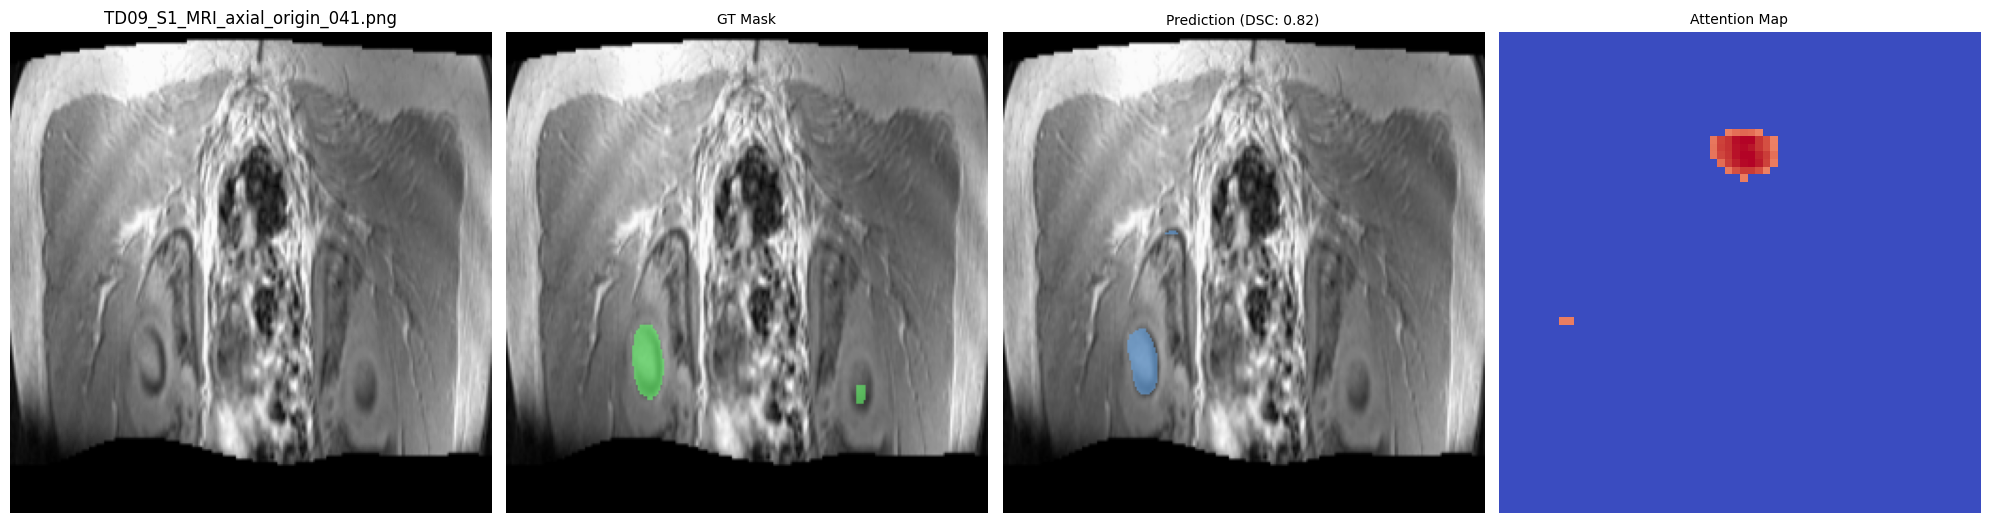

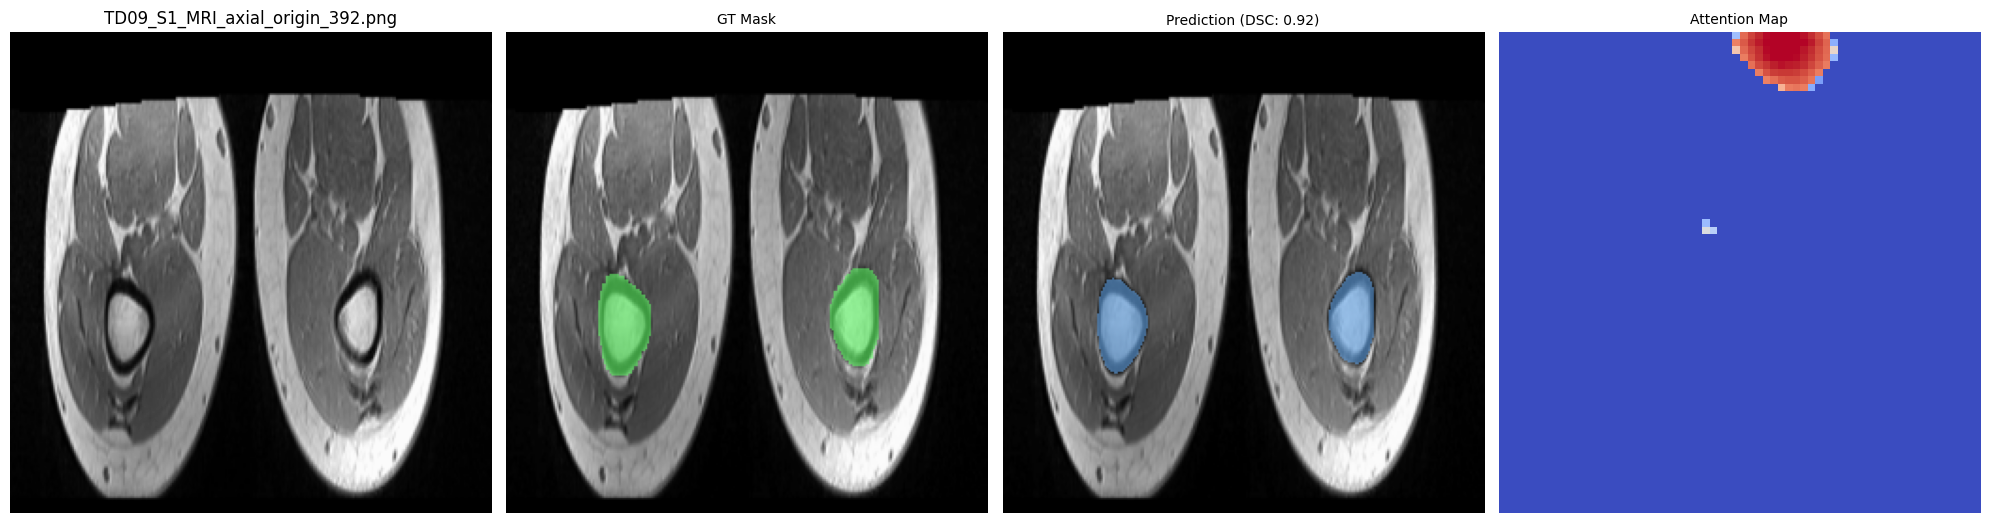

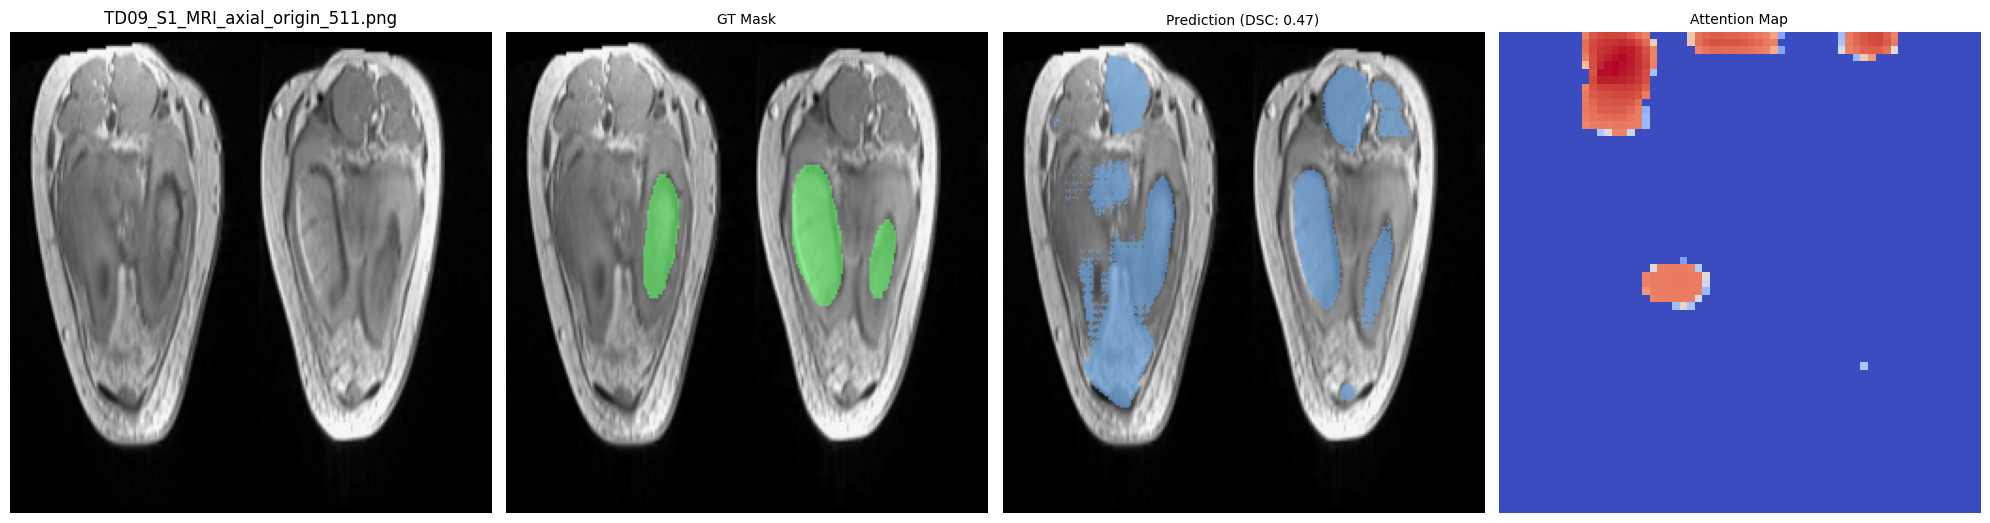

In [21]:
# Global variables for mouse callback
drawing_points = []

# Mouse callback function to capture points
def select_points(event, x, y, flags, param):
    global drawing_points
    if event == cv2.EVENT_LBUTTONDOWN:
        # Append the clicked point to the list
        drawing_points.append((x, y))
        # Draw a small circle at the clicked point
        cv2.circle(temp_img, (x, y), radius=5, color=(0, 0, 255), thickness=-1)
        cv2.imshow('Select Points', temp_img)

# Function to manually select points on an image
def get_selected_points(image_path):
    global temp_img

    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Cannot find or open image: {image_path}")

    # Create a copy of the image for drawing
    temp_img = img.copy()

    # Display the image and set up mouse callback
    cv2.namedWindow('Select Points')
    cv2.setMouseCallback('Select Points', select_points)

    while True:
        cv2.imshow('Select Points', temp_img)
        key = cv2.waitKey(1) & 0xFF

        # Press 'q' to finish point selection
        if key == ord('q'):
            break

    cv2.destroyAllWindows()
    cv2.waitKey(1)
    return drawing_points

def evaluate_1_volume_withattentionpoints(image_vol, model, device, slice_id=None, target_spacing=None, atten_map=None, selected_points=None):
    """
    Evaluate a single volume slice with optional attention map and selected points (prompts).
    """
    # Normalize volume data
    image_vol.data = image_vol.data / (image_vol.data.max() * 1.0)
    voxel_spacing = image_vol.spacing
    
    # Resample if target_spacing is provided
    if target_spacing and (voxel_spacing != target_spacing):
        resample = tio.Resample(target_spacing, image_interpolation='nearest')
        image_vol = resample(image_vol)
    
    # Get the slice
    image_vol = image_vol.data[0]
    slice_num = image_vol.shape[2]
    if slice_id is not None:
        if slice_id > slice_num:
            slice_id = -1
    else:
        slice_id = slice_num // 2
    
    # Convert slice data to [0, 255] range
    img_arr = image_vol[:, :, slice_id]
    img_arr = np.array((img_arr - img_arr.min()) / (img_arr.max() - img_arr.min() + 0.00001) * 255, dtype=np.uint8)
    
    # Convert single channel to RGB
    img_3c = np.tile(img_arr[:, :, None], [1, 1, 3])
    img = Image.fromarray(img_3c, 'RGB')
    Pil_img = img.copy()
    img = transforms.Resize((1024, 1024))(img)
    
    # Transform and normalize
    transform_img = transforms.Compose([
        transforms.ToTensor()
    ])
    img = transform_img(img)
    img = min_max_normalize(img)
    if img.mean() < 0.1:
        img = monai.transforms.AdjustContrast(gamma=0.8)(img)
    
    imgs = torch.unsqueeze(
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img), 0
    ).to(device)

    # Forward pass with optional attention and selected points (prompts)
    with torch.no_grad():
        img_emb = model.image_encoder(imgs)
        
        if selected_points is not None:
            sparse_emb, dense_emb = model.prompt_encoder(points=selected_points, boxes=None, masks=None)
        else:
            sparse_emb, dense_emb = model.prompt_encoder(points=None, boxes=None, masks=None)
        
        if atten_map is not None:
            img_emb = model.attention_fusion(img_emb, atten_map)
        
        pred, _ = model.mask_decoder(
            image_embeddings=img_emb,
            image_pe=model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_emb,
            dense_prompt_embeddings=dense_emb,
            multimask_output=True,
        )
        pred = pred[:, 1, :, :]
    ori_img = inverse_normalize(imgs.cpu()[0])
    
    return ori_img, pred, voxel_spacing, Pil_img, slice_id


def evaluateSlicePrediction(mask_pred, mask_name, slice_id):
    """
    Compute Dice Coefficient (DSC) between prediction and ground truth mask.
    """
    mask_path = os.path.join(gt_msk_folder, f"{mask_name}_{slice_id}.png")
    msk = Image.open(mask_path)
    msk = transforms.Resize((256, 256))(msk)

    if msk.mode != 'L':
        msk = msk.convert('L')
    msk_gt = (transforms.ToTensor()(msk) > 0).float()
    
    dsc_gt = dice_coeff(mask_pred.cpu(), msk_gt).item()
    print("dsc_gt:", dsc_gt)
    return msk_gt, dsc_gt


def predictSlice_points(image_name, lower_percentile, upper_percentile, slice_id, attention_enabled, selected_points=None):
    """
    Predict the mask for a single slice, optionally using an attention map and/or selected points (prompts).
    """
    img_path = os.path.join(img_folder, f"{image_name}_{slice_id}.png")
    image = Image.open(img_path)
    if image.mode != 'L':
        image = image.convert('L')
    
    # Convert image to tensor
    image_tensor = transforms.ToTensor()(image)
    
    # Adjust dimensions to [1, 1, H, W, 1]
    image_tensor = image_tensor.unsqueeze(0)
    image_tensor = image_tensor.unsqueeze(-1)
    
    # Data normalization
    lower_bound = torch_percentile(image_tensor, lower_percentile)
    upper_bound = torch_percentile(image_tensor, upper_percentile)
    image_tensor = torch.clamp(image_tensor, lower_bound, upper_bound)
    image_tensor = (image_tensor - lower_bound) / (upper_bound - lower_bound)
    
    # Remove batch dimension -> (1, x, y, z)
    image_tensor = image_tensor.squeeze(0)
    image1_vol = tio.ScalarImage(tensor=image_tensor)
    
    # Generate attention map
    atten_map = pred_attention(image1_vol, vnet, 0, device)
    atten_map = torch.unsqueeze(torch.tensor(atten_map), 0).float().to(device)

    # Evaluate using attention map or just points
    if attention_enabled:
        ori_img, pred_1, _, Pil_img1, _ = evaluate_1_volume_withattentionpoints(
            image1_vol, sam_fine_tune, device, slice_id=0, atten_map=atten_map, selected_points=selected_points
        )
    else:
        ori_img, pred_1, _, Pil_img1, _ = evaluate_1_volume_withattentionpoints(
            image1_vol, sam_fine_tune, device, slice_id=0, selected_points=selected_points
        )
    
    mask_pred = ((pred_1 > 0) == cls).float().cpu()
    return ori_img, mask_pred, atten_map


def visualizeSlicePrediction(ori_img, image_name, atten_map, msk_gt, mask_pred, dsc_gt, selected_points, output_folder, original_size):
    """
    Visualize original image, ground truth mask, predicted mask, and attention map.
    Optionally, display selected points on the image.
    """
    image = torchvision.transforms.Resize((args.out_size, args.out_size))(ori_img)[0]
    image_3d = np.repeat((image * 255).numpy().astype(np.uint8)[:, :, np.newaxis], 3, axis=2)
    
    pred_mask_auto = (mask_pred[0]) * 255
    mask = (msk_gt.cpu()[0] > 0) * 255
    
    target_prediction = [103, 169, 237]
    image_pred_auto = drawContour(image_3d.copy(), pred_mask_auto, target_prediction, size=-1, a=0.6)
    
    target_prediction = [100, 255, 106]
    image_mask = drawContour(image_3d.copy(), mask, target_prediction, size=-1, a=0.6)
    
    if selected_points is not None:
        # Draw selected points
        for point in selected_points:
            image_3d = cv2.circle(image_3d, point, radius=5, color=(255, 0, 0), thickness=3)

    # Save the third image (a[2]) directly
    third_image_output_file = os.path.join(output_folder, f"pre_mask_auto_{image_name}")
    third_image_resized = Image.fromarray(image_pred_auto.astype(np.uint8)).resize(original_size)
    third_image_resized.save(third_image_output_file)
    print(f"Saved third image (pre_mask_auto) resized to original size to {third_image_output_file}")
    
    fig, a = plt.subplots(1, 4, figsize=(20, 15))
    a[0].imshow(image, cmap='gray', vmin=0, vmax=1)
    a[0].set_title(image_name)
    a[0].axis(False)
    
    a[1].imshow(image_mask, cmap='gray', vmin=0, vmax=255)
    a[1].set_title('GT Mask', fontsize=10)
    a[1].axis(False)
    
    a[2].imshow(image_pred_auto, cmap='gray', vmin=0, vmax=255)
    a[2].set_title('Prediction (DSC: %.2f)' % dsc_gt, fontsize=10)
    a[2].axis(False)
    
    a[3].imshow(atten_map.cpu()[0], vmin=0, vmax=1, cmap='coolwarm')
    a[3].set_title('Attention Map', fontsize=10)
    a[3].axis(False)
    
    plt.tight_layout()

def save_segment_results_with_points(image_list, mask_list, output_folder, lower_percentile, upper_percentile, attention_enabled):
    """
    Test and save segmentation results for a list of images with manual point selection.

    Args:
        image_list (list): List of image file paths.
        mask_list (list): List of mask file paths corresponding to the images.
        output_folder (str): Folder to save the segmentation results.
        lower_percentile (int): Lower percentile for normalization.
        upper_percentile (int): Upper percentile for normalization.
        attention_enabled (bool): Whether to use the attention map.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for image_path, mask_path in zip(image_list, mask_list):
        # Extract slice ID from filename
        slice_id = os.path.basename(image_path).split('_')[-1].split('.')[0]

        # Extract base names for image and mask
        image_base_name = '_'.join(os.path.basename(image_path).split('_')[:5])  # E.g., "TD09_S1_MRI_axial"
        mask_base_name = '_'.join(os.path.basename(mask_path).split('_')[:6])   # E.g., "TD09_S1_L_femur-label_axial"

        print(f"Select points for image: {image_path}")
        points = get_selected_points(image_path)  # Manual point selection
        print("Selected points:", points)

        # Convert points to torch tensors for the SAM model
        coords = torch.tensor([points], dtype=torch.float32)  # Shape: (1, N, 2)
        labels = torch.tensor([[1] * len(points)], dtype=torch.int)  # Assume all points are foreground (label = 1)
        selected_points = (coords, labels)

        # Perform prediction with selected points
        ori_img, predictedSliceMask, atten_map = predictSlice_points(
            image_name=image_base_name,
            lower_percentile=lower_percentile,
            upper_percentile=upper_percentile,
            slice_id=slice_id,
            attention_enabled=attention_enabled,
            selected_points=selected_points
        )

        # Evaluate prediction
        msk_gt, dsc_gt = evaluateSlicePrediction(
            mask_pred=predictedSliceMask,
            mask_name=mask_base_name,
            slice_id=slice_id
        )

        ## Save segmentation result
        output_file = os.path.join(output_folder, f"segmented_{os.path.basename(image_path)}")
        
        # Resize predicted mask to match original image size
        original_image_path = os.path.join(img_folder, os.path.basename(image_path))
        original_image = Image.open(original_image_path)
        original_size = original_image.size  # Get original size (width, height)

        # Resize mask and save
        segmented_image = (predictedSliceMask[0].cpu().numpy() * 255).astype('uint8')
        segmented_image_resized = Image.fromarray(segmented_image).resize(original_size)
        segmented_image_resized.save(output_file)

        print(f"Saved segmented result to {output_file} (DSC: {dsc_gt:.4f})")

        # Visualize results
        visualizeSlicePrediction(
            ori_img=ori_img,
            image_name=os.path.basename(image_path),
            atten_map=atten_map,
            msk_gt=msk_gt,
            mask_pred=predictedSliceMask,
            dsc_gt=dsc_gt,
            selected_points=points,
            output_folder = output_folder,
            original_size = original_size
        )

image_folder = "./images"
mask_folder = "./masks"

test_images = [
    os.path.join(image_folder, "TD09_S1_MRI_axial_origin_041.png"),
    os.path.join(image_folder, "TD09_S1_MRI_axial_origin_392.png"),
    os.path.join(image_folder, "TD09_S1_MRI_axial_origin_511.png")
]
test_masks = [
    os.path.join(mask_folder, "TD09_S1_L_femur-label_axial_mask_041.png"),
    os.path.join(mask_folder, "TD09_S1_L_femur-label_axial_mask_392.png"),
    os.path.join(mask_folder, "TD09_S1_L_femur-label_axial_mask_511.png")
]

output_dir = "./segmentation_results_p"

# Run the test and save results
save_segment_results_with_points(test_images, test_masks, output_dir, lower_percentile=1, upper_percentile=99, attention_enabled=True)



Draw boxes for image: ./images/TD09_S1_MRI_axial_origin_041.png
Selected boxes: [[89, 92, 123, 121], [249, 104, 282, 130]]


/Users/mandywu/anaconda3/envs/torch/lib/python3.9/site-packages/torchio/transforms/transform.py:163: RuntimeWarning: Output shape (64, 64, 1) != target shape (64, 64, 64). Fixing with CropOrPad
  transformed = self.apply_transform(subject)
/var/folders/9_/k4h2cghj2s3bg4nf0hlx69p40000gn/T/ipykernel_90727/172490649.py:66: DeprecationWarning: Call to deprecated function (or staticmethod) data. (Setting the image data with the property setter is deprecated. Use the set_data() method instead) -- Deprecated since version 0.18.16.
  image_vol.data = image_vol.data / (image_vol.data.max() * 1.0)


dsc_gt: 0.8165322542190552
Saved segmented result to ./segmentation_results_b/segmented_TD09_S1_MRI_axial_origin_041.png (DSC: 0.8165)
Saved third image (pre_mask_auto) resized to original size to ./segmentation_results_b/pre_mask_auto_TD09_S1_MRI_axial_origin_041.png
Draw boxes for image: ./images/TD09_S1_MRI_axial_origin_392.png


/Users/mandywu/anaconda3/envs/torch/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Selected boxes: [[64, 71, 115, 112], [234, 77, 284, 116]]
dsc_gt: 0.919098436832428
Saved segmented result to ./segmentation_results_b/segmented_TD09_S1_MRI_axial_origin_392.png (DSC: 0.9191)
Saved third image (pre_mask_auto) resized to original size to ./segmentation_results_b/pre_mask_auto_TD09_S1_MRI_axial_origin_392.png
Draw boxes for image: ./images/TD09_S1_MRI_axial_origin_511.png
Selected boxes: [[99, 46, 132, 89], [210, 43, 255, 90], [260, 59, 296, 106]]
dsc_gt: 0.558752715587616
Saved segmented result to ./segmentation_results_b/segmented_TD09_S1_MRI_axial_origin_511.png (DSC: 0.5588)
Saved third image (pre_mask_auto) resized to original size to ./segmentation_results_b/pre_mask_auto_TD09_S1_MRI_axial_origin_511.png


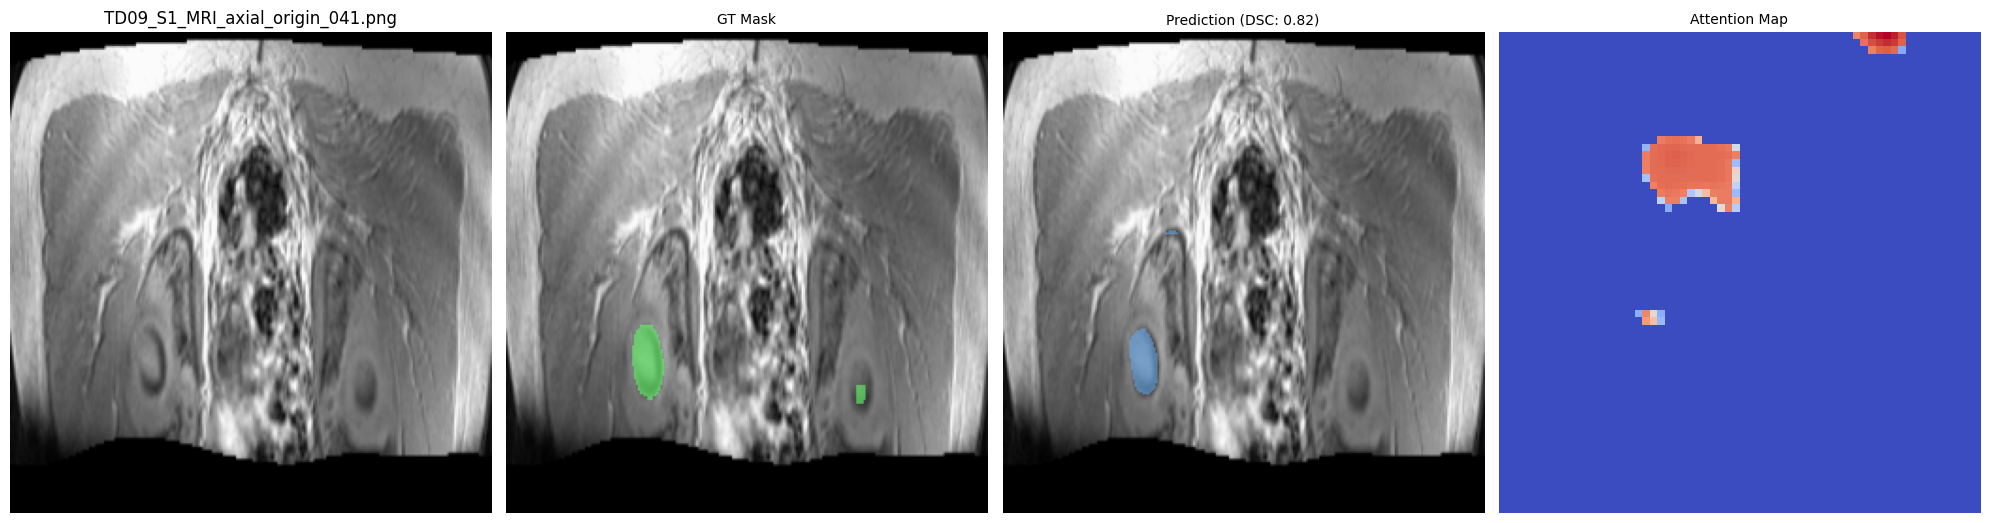

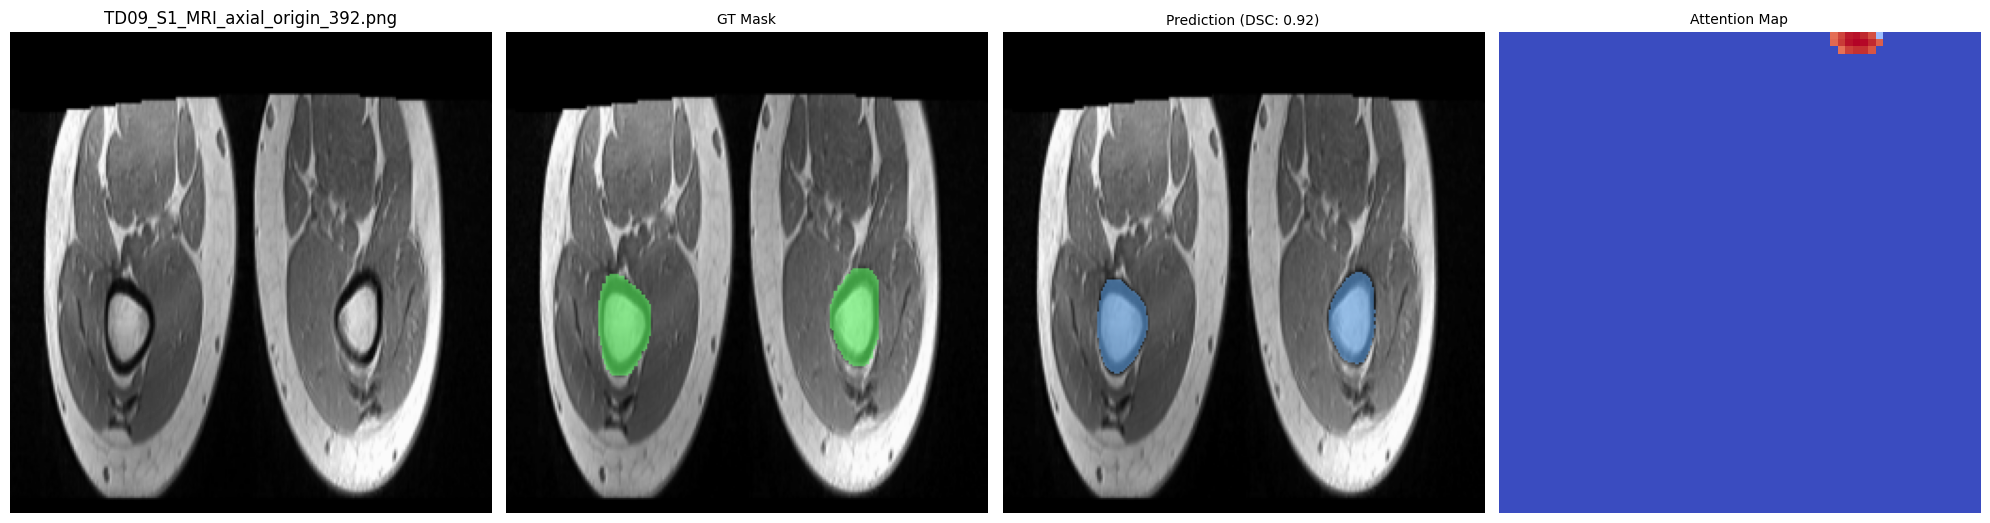

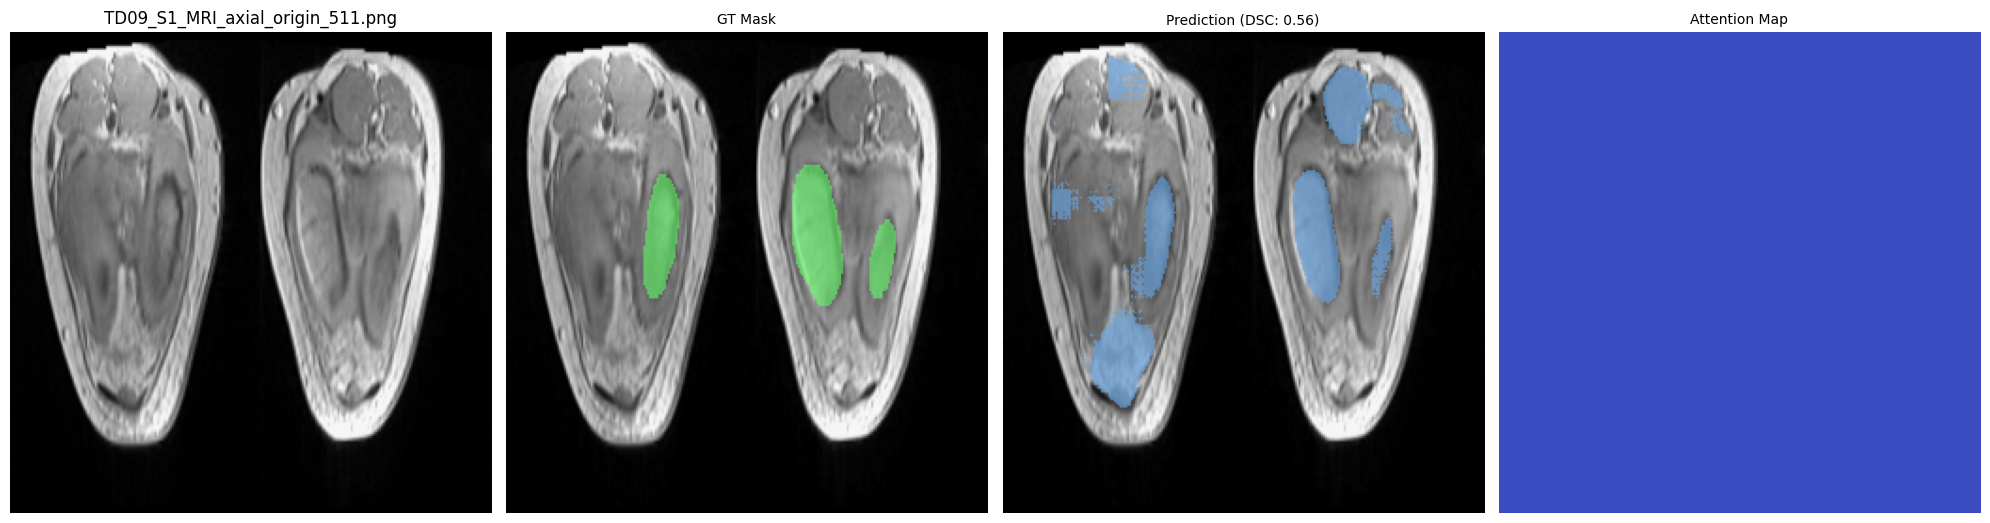

In [25]:
# Global variables
drawing = False
x1, y1 = -1, -1
x2, y2 = -1, -1
boxes = []

def draw_box(event, x, y, flags, param):
    global drawing, x1, y1, x2, y2, img, temp_img, boxes

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        x1, y1 = x, y
        x2, y2 = x, y  # init

    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            temp_img = img.copy()
            cv2.rectangle(temp_img, (x1, y1), (x, y), (0, 255, 0), 2)
            cv2.imshow('Draw Box', temp_img)

    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        x2, y2 = x, y
        # Add the box to the list
        boxes.append([x1, y1, x2, y2])
        # Draw rectangle on the main image
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.imshow('Draw Box', img)

def get_selected_boxes(image_path):
    global img, temp_img, boxes
    boxes = []

    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Cannot find or open image: {image_path}")

    # Create a copy of the original image
    temp_img = img.copy()

    # Display the image and set up the mouse callback
    cv2.namedWindow('Draw Box')
    cv2.setMouseCallback('Draw Box', draw_box)

    while True:
        cv2.imshow('Draw Box', img)
        key = cv2.waitKey(1) & 0xFF

        if key == ord('q'):  # Quit drawing
            break
        elif key == ord('r'):  # Reset the image
            img = temp_img.copy()
            boxes = []
            cv2.imshow('Draw Box', img)

    cv2.destroyAllWindows()
    cv2.waitKey(1)
    return boxes

def evaluate_1_volume_withattentionbox(image_vol, model, device, slice_id=None, target_spacing=None, atten_map=None, selected_box=None):
    """
    Evaluate a single volume slice with optional attention map and selected points (prompts).
    """
    # Normalize volume data
    image_vol.data = image_vol.data / (image_vol.data.max() * 1.0)
    voxel_spacing = image_vol.spacing
    
    # Resample if target_spacing is provided
    if target_spacing and (voxel_spacing != target_spacing):
        resample = tio.Resample(target_spacing, image_interpolation='nearest')
        image_vol = resample(image_vol)
    
    # Get the slice
    image_vol = image_vol.data[0]
    slice_num = image_vol.shape[2]
    if slice_id is not None:
        if slice_id > slice_num:
            slice_id = -1
    else:
        slice_id = slice_num // 2
    
    # Convert slice data to [0, 255] range
    img_arr = image_vol[:, :, slice_id]
    img_arr = np.array((img_arr - img_arr.min()) / (img_arr.max() - img_arr.min() + 0.00001) * 255, dtype=np.uint8)
    
    # Convert single channel to RGB
    img_3c = np.tile(img_arr[:, :, None], [1, 1, 3])
    img = Image.fromarray(img_3c, 'RGB')
    Pil_img = img.copy()
    img = transforms.Resize((1024, 1024))(img)
    
    # Transform and normalize
    transform_img = transforms.Compose([
        transforms.ToTensor()
    ])
    img = transform_img(img)
    img = min_max_normalize(img)
    if img.mean() < 0.1:
        img = monai.transforms.AdjustContrast(gamma=0.8)(img)
    
    imgs = torch.unsqueeze(
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img), 0
    ).to(device)

    # Forward pass with optional attention and selected points (prompts)
    with torch.no_grad():
        img_emb = model.image_encoder(imgs)

        if selected_box is not None:
            # boxes=selected_box, points=None
            sparse_emb, dense_emb = model.prompt_encoder(points=None, boxes=selected_box, masks=None)
        else:
            sparse_emb, dense_emb = model.prompt_encoder(points=None, boxes=None, masks=None)
        
        if atten_map is not None:
            img_emb = model.attention_fusion(img_emb, atten_map)
        
        pred, _ = model.mask_decoder(
            image_embeddings=img_emb,
            image_pe=model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_emb,
            dense_prompt_embeddings=dense_emb,
            multimask_output=True,
        )
        pred = pred[:, 1, :, :]
    ori_img = inverse_normalize(imgs.cpu()[0])
    
    return ori_img, pred, voxel_spacing, Pil_img, slice_id


def evaluateSlicePrediction(mask_pred, mask_name, slice_id):
    """
    Compute Dice Coefficient (DSC) between prediction and ground truth mask.
    """
    mask_path = os.path.join(gt_msk_folder, f"{mask_name}_{slice_id}.png")
    msk = Image.open(mask_path)
    msk = transforms.Resize((256, 256))(msk)

    if msk.mode != 'L':
        msk = msk.convert('L')
    msk_gt = (transforms.ToTensor()(msk) > 0).float()
    
    dsc_gt = dice_coeff(mask_pred.cpu(), msk_gt).item()
    print("dsc_gt:", dsc_gt)
    return msk_gt, dsc_gt


def predictSlice(image_name, lower_percentile, upper_percentile, slice_id, attention_enabled, selected_box=None):
    """
    Predict the mask for a single slice, optionally using an attention map and/or selected points (prompts).
    """
    img_path = os.path.join(img_folder, f"{image_name}_{slice_id}.png")
    image = Image.open(img_path)
    if image.mode != 'L':
        image = image.convert('L')
    
    # Convert image to tensor
    image_tensor = transforms.ToTensor()(image)
    
    # Adjust dimensions to [1, 1, H, W, 1]
    image_tensor = image_tensor.unsqueeze(0)
    image_tensor = image_tensor.unsqueeze(-1)
    
    # Data normalization
    lower_bound = torch_percentile(image_tensor, lower_percentile)
    upper_bound = torch_percentile(image_tensor, upper_percentile)
    image_tensor = torch.clamp(image_tensor, lower_bound, upper_bound)
    image_tensor = (image_tensor - lower_bound) / (upper_bound - lower_bound)
    
    # Remove batch dimension -> (1, x, y, z)
    image_tensor = image_tensor.squeeze(0)
    image1_vol = tio.ScalarImage(tensor=image_tensor)
    
    # Generate attention map
    atten_map = pred_attention(image1_vol, vnet, 0, device)
    atten_map = torch.unsqueeze(torch.tensor(atten_map), 0).float().to(device)

    # Evaluate using attention map or just points
    if attention_enabled:
        ori_img, pred_1, _, Pil_img1, _ = evaluate_1_volume_withattentionbox(
            image1_vol, sam_fine_tune, device, slice_id=0, atten_map=atten_map, selected_box=selected_box
        )
    else:
        # No attention map
        ori_img, pred_1, _, Pil_img1, _ = evaluate_1_volume_withattentionbox(
            image1_vol, sam_fine_tune, device, slice_id=0, selected_box=selected_box
        )
    
    mask_pred = ((pred_1 > 0) == cls).float().cpu()
    return ori_img, mask_pred, atten_map


def visualizeSlicePrediction(ori_img, image_name, atten_map, msk_gt, mask_pred, dsc_gt, selected_box, output_folder, original_size):
    """
    Visualize original image, ground truth mask, predicted mask, and attention map.
    Optionally, display selected points on the image.
    """
    image = torchvision.transforms.Resize((args.out_size, args.out_size))(ori_img)[0]
    image_3d = np.repeat((image * 255).numpy().astype(np.uint8)[:, :, np.newaxis], 3, axis=2)
    
    pred_mask_auto = (mask_pred[0]) * 255
    mask = (msk_gt.cpu()[0] > 0) * 255
    
    target_prediction = [103, 169, 237]
    image_pred_auto = drawContour(image_3d.copy(), pred_mask_auto, target_prediction, size=-1, a=0.6)
    
    target_prediction = [100, 255, 106]
    image_mask = drawContour(image_3d.copy(), mask, target_prediction, size=-1, a=0.6)
    
    # If bounding box is provided, draw it
    if selected_box is not None:
        # Suppose shape is (1, 4) or (B, 4)
        box_np = selected_box.cpu().numpy() if torch.is_tensor(selected_box) else np.array(selected_box)
        box_np = box_np.reshape(-1, 4)  # ensure shape [N, 4]

        for (x1, y1, x2, y2) in box_np:
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            cv2.rectangle(image_3d, (x1, y1), (x2, y2), color=(255,0,0), thickness=2)

    # Save the third image (a[2]) directly
    third_image_output_file = os.path.join(output_folder, f"pre_mask_auto_{image_name}")
    third_image_resized = Image.fromarray(image_pred_auto.astype(np.uint8)).resize(original_size)
    third_image_resized.save(third_image_output_file)
    print(f"Saved third image (pre_mask_auto) resized to original size to {third_image_output_file}")

    fig, a = plt.subplots(1, 4, figsize=(20, 15))
    a[0].imshow(image, cmap='gray', vmin=0, vmax=1)
    a[0].set_title(image_name)
    a[0].axis(False)
    
    a[1].imshow(image_mask, cmap='gray', vmin=0, vmax=255)
    a[1].set_title('GT Mask', fontsize=10)
    a[1].axis(False)
    
    a[2].imshow(image_pred_auto, cmap='gray', vmin=0, vmax=255)
    a[2].set_title('Prediction (DSC: %.2f)' % dsc_gt, fontsize=10)
    a[2].axis(False)
    
    a[3].imshow(atten_map.cpu()[0], vmin=0, vmax=1, cmap='coolwarm')
    a[3].set_title('Attention Map', fontsize=10)
    a[3].axis(False)
    
    plt.tight_layout()

def save_segment_results_with_boxes(image_list, mask_list, output_folder, lower_percentile, upper_percentile, attention_enabled):
    """
    Test and save segmentation results for a list of images with manually drawn boxes.

    Args:
        image_list (list): List of image file paths.
        mask_list (list): List of mask file paths corresponding to the images.
        output_folder (str): Folder to save the segmentation results.
        lower_percentile (int): Lower percentile for normalization.
        upper_percentile (int): Upper percentile for normalization.
        attention_enabled (bool): Whether to use the attention map.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for image_path, mask_path in zip(image_list, mask_list):
        # Extract slice ID from filename
        slice_id = os.path.basename(image_path).split('_')[-1].split('.')[0]

        # Extract base names for image and mask
        image_base_name = '_'.join(os.path.basename(image_path).split('_')[:5])
        mask_base_name = '_'.join(os.path.basename(mask_path).split('_')[:6])

        print(f"Draw boxes for image: {image_path}")
        boxes = get_selected_boxes(image_path)  # Manual box drawing
        print("Selected boxes:", boxes)

        # Convert boxes to torch tensor
        selected_box = torch.tensor(boxes, dtype=torch.float32)

        # Perform prediction with selected boxes
        ori_img, predictedSliceMask, atten_map = predictSlice(
            image_name=image_base_name,
            lower_percentile=lower_percentile,
            upper_percentile=upper_percentile,
            slice_id=slice_id,
            attention_enabled=attention_enabled,
            selected_box=selected_box
        )

        # Evaluate prediction
        msk_gt, dsc_gt = evaluateSlicePrediction(
            mask_pred=predictedSliceMask,
            mask_name=mask_base_name,
            slice_id=slice_id
        )

        ## Save segmentation result
        output_file = os.path.join(output_folder, f"segmented_{os.path.basename(image_path)}")
        
        # Resize predicted mask to match original image size
        original_image_path = os.path.join(img_folder, os.path.basename(image_path))
        original_image = Image.open(original_image_path)
        original_size = original_image.size  # Get original size (width, height)

        # Resize mask and save
        segmented_image = (predictedSliceMask[0].cpu().numpy() * 255).astype('uint8')
        segmented_image_resized = Image.fromarray(segmented_image).resize(original_size)
        segmented_image_resized.save(output_file)

        print(f"Saved segmented result to {output_file} (DSC: {dsc_gt:.4f})")

        # Visualize results
        visualizeSlicePrediction(
            ori_img=ori_img,
            image_name=os.path.basename(image_path),
            atten_map=atten_map,
            msk_gt=msk_gt,
            mask_pred=predictedSliceMask,
            dsc_gt=dsc_gt,
            selected_box=boxes,
            output_folder = output_folder,
            original_size = original_size
        )

image_folder = "./images"
mask_folder = "./masks"

test_images = [
    os.path.join(image_folder, "TD09_S1_MRI_axial_origin_041.png"),
    os.path.join(image_folder, "TD09_S1_MRI_axial_origin_392.png"),
    os.path.join(image_folder, "TD09_S1_MRI_axial_origin_511.png")
]
test_masks = [
    os.path.join(mask_folder, "TD09_S1_L_femur-label_axial_mask_041.png"),
    os.path.join(mask_folder, "TD09_S1_L_femur-label_axial_mask_392.png"),
    os.path.join(mask_folder, "TD09_S1_L_femur-label_axial_mask_511.png")
]

output_dir = "./segmentation_results_b"

# Run the test and save results with boxes
save_segment_results_with_boxes(
    test_images,
    test_masks,
    output_dir,
    lower_percentile=1,
    upper_percentile=99,
    attention_enabled=True
)


In [15]:
img_folder = "MRI_testdata/TD09_S1_MRI_axial_origin"
mask_folder = "MRI_testdata/TD09_S1_MRI_axial_mask"

def evaluateSlicePrediction(mask_pred, mask_name, slice_id):
    # Read corresponding PNG mask
    msk_path = os.path.join(mask_folder, f"{mask_name}.png")
    msk = Image.open(msk_path)
    msk = transforms.Resize((256,256))(msk)

    # Convert RGB image to grayscale if needed
    if msk.mode != 'L':
        msk = msk.convert('L')
    msk_gt = (transforms.ToTensor()(msk)>0).float()
    
    dsc_gt = dice_coeff(mask_pred.cpu(), msk_gt).item()
    print("dsc_gt:", dsc_gt)
    return msk_gt, dsc_gt

def predictSlice(image_name, lower_percentile, upper_percentile, slice_id, attention_enabled):
    # Read PNG image
    img_path = os.path.join(img_folder, f"{image_name}.png")
    image = Image.open(img_path)
    if image.mode != 'L':
        image = image.convert('L')
    
    # Convert to tensor and adjust dimensions
    image_tensor = transforms.ToTensor()(image)  # [1, H, W]
    
    # Adjust dimensions to [1, 1, H, W, 1] (channels, x, y, z)
    image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension [1, 1, H, W]
    image_tensor = image_tensor.unsqueeze(-1)  # Add z dimension [1, 1, H, W, 1]
    
    # Data normalization
    lower_bound = torch_percentile(image_tensor, lower_percentile)
    upper_bound = torch_percentile(image_tensor, upper_percentile)
    image_tensor = torch.clamp(image_tensor, lower_bound, upper_bound)
    image_tensor = (image_tensor - lower_bound) / (upper_bound - lower_bound)
    
    # Rearrange dimensions to (1, x, y, z)
    image_tensor = image_tensor.squeeze(0)  # Remove batch dimension
    
    # Create torchio ScalarImage object
    image1_vol = tio.ScalarImage(tensor=image_tensor)
    
    atten_map = pred_attention(image1_vol, vnet, 0, device)  # slice_id set to 0 as we only have one slice
    atten_map = torch.unsqueeze(torch.tensor(atten_map), 0).float().to(device)
    
    if attention_enabled:
        ori_img, pred_1, _, Pil_img1, _ = evaluate_1_volume_withattention(
            image1_vol, sam_fine_tune, device, slice_id=0, atten_map=atten_map)
    else:
        ori_img, pred_1, _, Pil_img1, _ = evaluate_1_volume_withattention(
            image1_vol, sam_fine_tune, device, slice_id=0)
    
    mask_pred = ((pred_1>0)==cls).float().cpu()
    return ori_img, mask_pred, atten_map

def save_segment_results(lower_percentile, upper_percentile, attention_enabled):
    """
    Test and calculate Dice Scores for all images in MRI_testdata/TD09_S1_MRI_axial_origin.

    Args:
        lower_percentile (int): Lower percentile for normalization.
        upper_percentile (int): Upper percentile for normalization.
        attention_enabled (bool): Whether to use the attention map.
    """
    origin_folder = "MRI_testdata/TD09_S1_MRI_axial_origin"
    mask_folder = "MRI_testdata/TD09_S1_MRI_axial_mask"
    output_file = "MRI_testdata/09s1.txt"

    image_list = sorted([f for f in os.listdir(origin_folder) if f.endswith('.png')])
    mask_list = sorted([f for f in os.listdir(mask_folder) if f.endswith('.png')])

    dice_scores = []  # List to store Dice Scores for each image

    for image_name, mask_name in zip(image_list, mask_list):
        # Extract slice ID from filename
        slice_id = os.path.basename(image_name).split('_')[-1].split('.')[0]

        # Perform prediction
        ori_img, predictedSliceMask, atten_map = predictSlice(
            image_name=os.path.splitext(image_name)[0],
            lower_percentile=lower_percentile,
            upper_percentile=upper_percentile,
            slice_id=slice_id,
            attention_enabled=attention_enabled
        )

        # Evaluate prediction
        _, dsc_gt = evaluateSlicePrediction(
            mask_pred=predictedSliceMask,
            mask_name=os.path.splitext(mask_name)[0],
            slice_id=slice_id
        )

        # Store the Dice Score
        dice_scores.append((image_name, dsc_gt))

    # Write Dice Scores to file
    # Write Dice Scores to file
    with open(output_file, "w") as file:
        for _, dsc in dice_scores:
            file.write(f"{dsc:.2f}\n")

    # Print a confirmation message
    print(f"Results saved to {output_file}")

# Run the test and calculate Dice Scores
save_segment_results(lower_percentile=1, upper_percentile=99, attention_enabled=True)


dsc_gt: 1.0
dsc_gt: 1.0
dsc_gt: 1.0
dsc_gt: 1.0
dsc_gt: 4.975121328243404e-07
dsc_gt: 2.3364479773135827e-07
dsc_gt: 8.802815898434346e-08
dsc_gt: 4.646840068289748e-08
dsc_gt: 4.364905947795705e-08
dsc_gt: 4.2643922171237136e-08
dsc_gt: 4.273504217167101e-08
dsc_gt: 4.545454501680979e-08
dsc_gt: 4.405286091468952e-08
dsc_gt: 4.088307292704485e-08
dsc_gt: 4.053506330592427e-08
dsc_gt: 4.345936588379118e-08
dsc_gt: 4.098360406601387e-08
dsc_gt: 3.843197404762577e-08
dsc_gt: 3.853564578548685e-08
dsc_gt: 3.6023052985001414e-08
dsc_gt: 3.44115598238659e-08
dsc_gt: 3.344481669387278e-08
dsc_gt: 3.211303578609659e-08
dsc_gt: 3.15556967223074e-08
dsc_gt: 2.9171527415883247e-08
dsc_gt: 2.96559896639792e-08
dsc_gt: 3.34672023427629e-08
dsc_gt: 4.863813174438292e-08
dsc_gt: 4.237287853925409e-08
dsc_gt: 4.330879121994258e-08
dsc_gt: 6.002400709803624e-08
dsc_gt: 6.238302319161448e-08
dsc_gt: 2.0618551843654132e-07
dsc_gt: 1.479289579719989e-07
dsc_gt: 1.249999712626959e-07
dsc_gt: 6.98811959409

In [18]:
img_folder = "MRI_testdata/TD10_S1_MRI_axial_origin"
mask_folder = "MRI_testdata/TD10_S1_MRI_axial_mask"

def evaluateSlicePrediction(mask_pred, mask_name, slice_id):
    # Read corresponding PNG mask
    msk_path = os.path.join(mask_folder, f"{mask_name}.png")
    msk = Image.open(msk_path)
    msk = transforms.Resize((256,256))(msk)

    # Convert RGB image to grayscale if needed
    if msk.mode != 'L':
        msk = msk.convert('L')
    msk_gt = (transforms.ToTensor()(msk)>0).float()
    
    dsc_gt = dice_coeff(mask_pred.cpu(), msk_gt).item()
    print("dsc_gt:", dsc_gt)
    return msk_gt, dsc_gt

def predictSlice(image_name, lower_percentile, upper_percentile, slice_id, attention_enabled):
    # Read PNG image
    img_path = os.path.join(img_folder, f"{image_name}.png")
    image = Image.open(img_path)
    if image.mode != 'L':
        image = image.convert('L')
    
    # Convert to tensor and adjust dimensions
    image_tensor = transforms.ToTensor()(image)  # [1, H, W]
    
    # Adjust dimensions to [1, 1, H, W, 1] (channels, x, y, z)
    image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension [1, 1, H, W]
    image_tensor = image_tensor.unsqueeze(-1)  # Add z dimension [1, 1, H, W, 1]
    
    # Data normalization
    lower_bound = torch_percentile(image_tensor, lower_percentile)
    upper_bound = torch_percentile(image_tensor, upper_percentile)
    image_tensor = torch.clamp(image_tensor, lower_bound, upper_bound)
    image_tensor = (image_tensor - lower_bound) / (upper_bound - lower_bound)
    
    # Rearrange dimensions to (1, x, y, z)
    image_tensor = image_tensor.squeeze(0)  # Remove batch dimension
    
    # Create torchio ScalarImage object
    image1_vol = tio.ScalarImage(tensor=image_tensor)
    
    atten_map = pred_attention(image1_vol, vnet, 0, device)  # slice_id set to 0 as we only have one slice
    atten_map = torch.unsqueeze(torch.tensor(atten_map), 0).float().to(device)
    
    if attention_enabled:
        ori_img, pred_1, _, Pil_img1, _ = evaluate_1_volume_withattention(
            image1_vol, sam_fine_tune, device, slice_id=0, atten_map=atten_map)
    else:
        ori_img, pred_1, _, Pil_img1, _ = evaluate_1_volume_withattention(
            image1_vol, sam_fine_tune, device, slice_id=0)
    
    mask_pred = ((pred_1>0)==cls).float().cpu()
    return ori_img, mask_pred, atten_map

def save_segment_results(lower_percentile, upper_percentile, attention_enabled):
    """
    Test and calculate Dice Scores for all images in MRI_testdata/TD09_S1_MRI_axial_origin.

    Args:
        lower_percentile (int): Lower percentile for normalization.
        upper_percentile (int): Upper percentile for normalization.
        attention_enabled (bool): Whether to use the attention map.
    """
    origin_folder = "MRI_testdata/TD10_S1_MRI_axial_origin"
    mask_folder = "MRI_testdata/TD10_S1_MRI_axial_mask"
    output_file = "MRI_testdata/10s1.txt"

    image_list = sorted([f for f in os.listdir(origin_folder) if f.endswith('.png')])
    mask_list = sorted([f for f in os.listdir(mask_folder) if f.endswith('.png')])

    dice_scores = []  # List to store Dice Scores for each image

    for image_name, mask_name in zip(image_list, mask_list):
        # Extract slice ID from filename
        slice_id = os.path.basename(image_name).split('_')[-1].split('.')[0]

        # Perform prediction
        ori_img, predictedSliceMask, atten_map = predictSlice(
            image_name=os.path.splitext(image_name)[0],
            lower_percentile=lower_percentile,
            upper_percentile=upper_percentile,
            slice_id=slice_id,
            attention_enabled=attention_enabled
        )

        # Evaluate prediction
        _, dsc_gt = evaluateSlicePrediction(
            mask_pred=predictedSliceMask,
            mask_name=os.path.splitext(mask_name)[0],
            slice_id=slice_id
        )

        # Store the Dice Score
        dice_scores.append((image_name, dsc_gt))

    with open(output_file, "w") as file:
        for _, dsc in dice_scores:
            file.write(f"{dsc:.2f}\n")

    # Print a confirmation message
    print(f"Results saved to {output_file}")

# Run the test and calculate Dice Scores
save_segment_results(lower_percentile=1, upper_percentile=99, attention_enabled=True)


dsc_gt: 1.0
dsc_gt: 1.0
dsc_gt: 1.0
dsc_gt: 1.0
dsc_gt: 4.219407401251374e-07
dsc_gt: 3.0211469947971636e-07
dsc_gt: 6.211175787029788e-07
dsc_gt: 1.4285693623605766e-06
dsc_gt: 6.561678844718699e-08
dsc_gt: 4.568295963736091e-08
dsc_gt: 5.081300358256158e-08
dsc_gt: 5.903187272338073e-08
dsc_gt: 4.640371287223388e-08
dsc_gt: 4.312203571998907e-08
dsc_gt: 4.393672980995689e-08
dsc_gt: 4.35729852199529e-08
dsc_gt: 4.97760019868565e-08
dsc_gt: 4.6707146594826554e-08
dsc_gt: 4.2716788328789335e-08
dsc_gt: 4.2826552970609555e-08
dsc_gt: 3.992015962239748e-08
dsc_gt: 3.877471854707437e-08
dsc_gt: 3.7216224768599204e-08
dsc_gt: 3.8491144493946194e-08
dsc_gt: 3.623188149504131e-08
dsc_gt: 4.555808530426475e-08
dsc_gt: 5.117706791679666e-08
dsc_gt: 6.26959177907338e-08
dsc_gt: 3.6310819240270575e-08
dsc_gt: 6.188118106820184e-08
dsc_gt: 4.960316957181021e-08
dsc_gt: 4.201680425808263e-08
dsc_gt: 5.2910049674892434e-08
dsc_gt: 5.488473675541172e-08
dsc_gt: 3.1695719826529967e-08
dsc_gt: 5.26592

In [2]:
file_path = 'MRI_testdata/09s1.txt' 

total_sum = 0
count = 0

with open(file_path, 'r') as file:
    for line in file:
        try:
            num = float(line.strip())
            total_sum += num
            count += 1
        except ValueError:
            print(f"Skipping non-numeric line: {line.strip()}")

if count > 0:
    average = total_sum / count
    print(f"total: {count}, average: {average}")
else:
    print("nonumbers")


total: 547, average: 0.7285923217550299
